  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 16.8 MB/s eta 0:00:00
  Created wheel for genomic_benchmarks: filename=genomic_benchmarks-0.0.9-py3-none-any.whl size=22506 sha256=839fb17f95628012519c0c918c1efc9749836ebbc086c160c74a3e7e7eee1a62
  Stored in directory: /root/.cache/pip/wheels/f9/43/d4/2daa540dbbe508826ceaaf9e71728357485cb4a7b4a40e595e
Successfully built genomic_benchmarks


/usr/local/lib/python3.11/dist-packages/genomic_benchmarks/utils/datasets.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Dataset `human_nontata_promoters` has 2 classes: negative, positive.

All lengths of genomic intervals equals 251.

Totally 36131 sequences have been found, 27097 for training and 9034 for testing.


Downloading...
From (original): https://drive.google.com/uc?id=1VdUg0Zu8yfLS6QesBXwGz1PIQrTW3Ze4
From (redirected): https://drive.google.com/uc?id=1VdUg0Zu8yfLS6QesBXwGz1PIQrTW3Ze4&confirm=t&uuid=edcce155-c9f4-4242-946c-1b4c584edfb1
To: /root/.genomic_benchmarks/human_nontata_promoters.zip
100%|██████████| 11.8M/11.8M [00:00<00:00, 254MB/s]


Loaded 36131 sequences


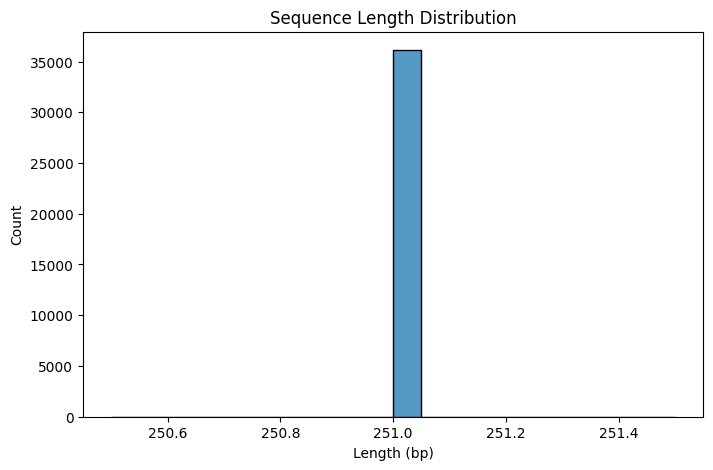

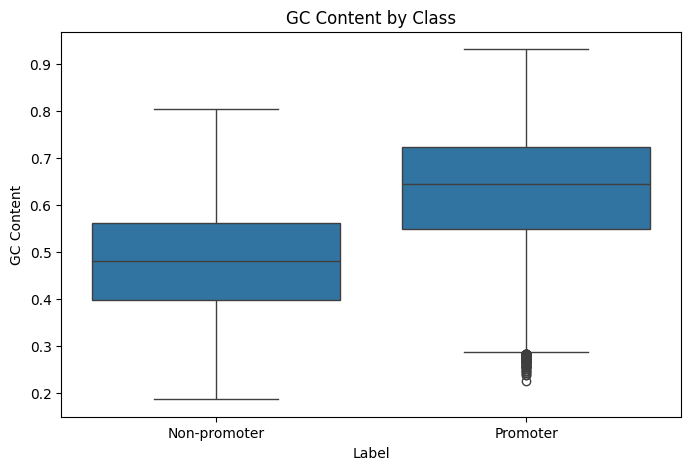

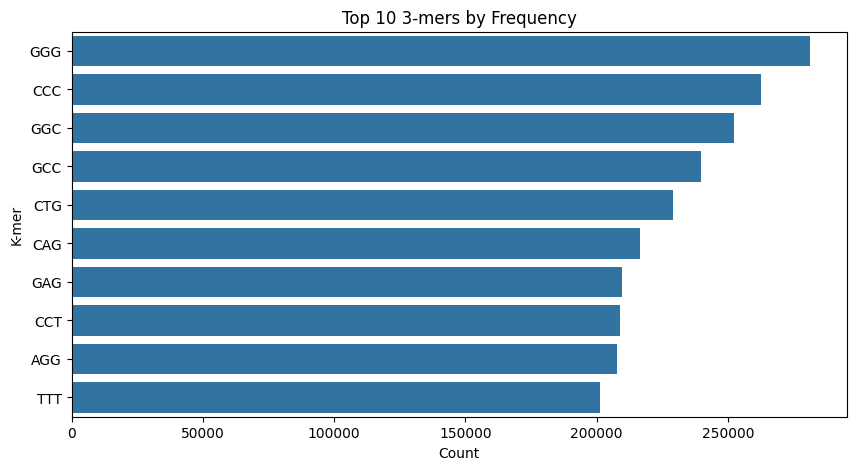

Random Forest Accuracy: 0.88


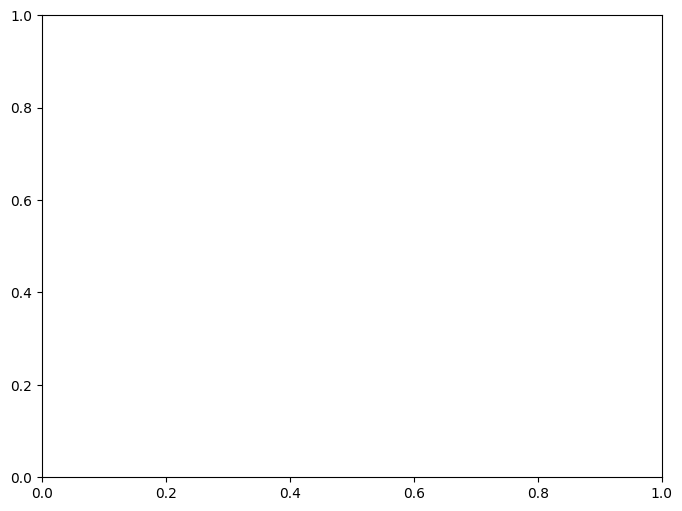

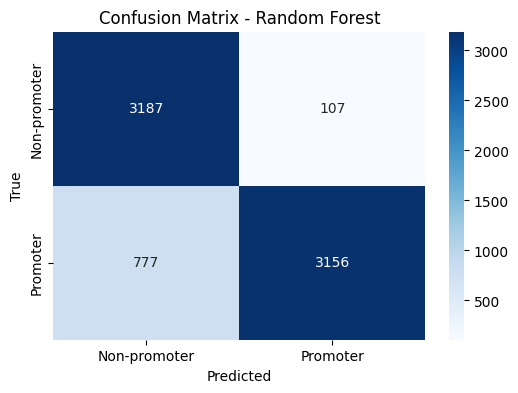

SVM Accuracy: 0.86


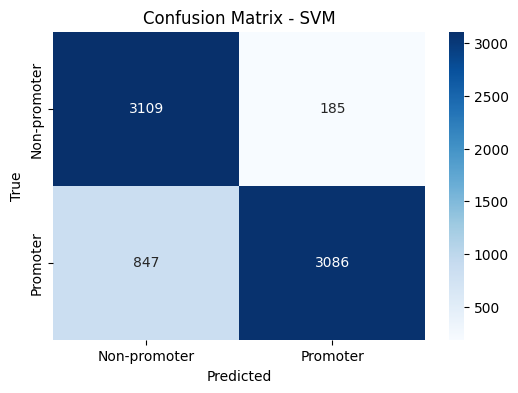

Logistic Regression Accuracy: 0.81


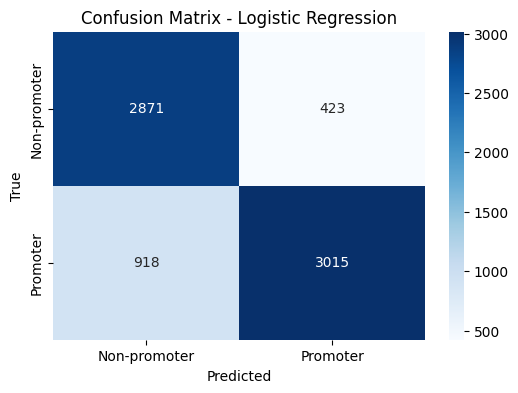

<ipython-input-1-a79045629483>:156: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.values()), y=list(results.keys()), palette='Blues_d')


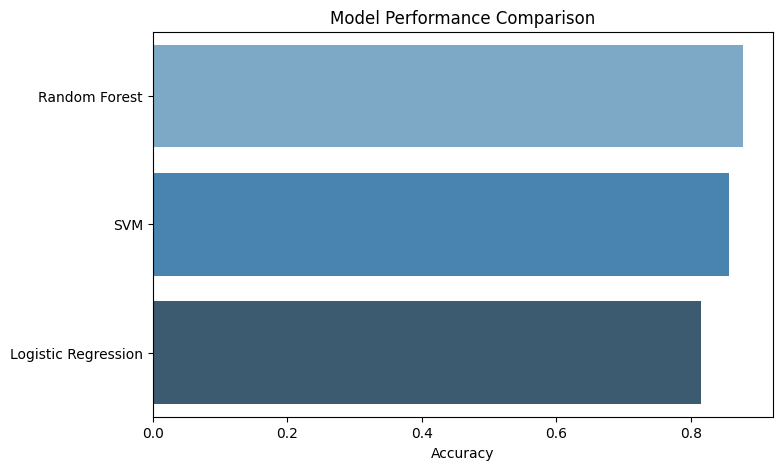

In [1]:
# # Gene Sequence Classification: Promoter vs. Non-Promoter
#
# This notebook runs in **Google Colab** to classify DNA sequences as promoters or non-promoters using the `human_nontata_promoters` dataset from UCI Genomic Benchmarks. We extract k-mer features and compare Random Forest, SVM, and Logistic Regression models. This project demonstrates skills in bioinformatics and AI/ML for a GitHub portfolio.

# ## Install Dependencies
# Install `genomic_benchmarks` and `biopython`, as they are not pre-installed in Colab.

!pip install genomic_benchmarks biopython

# ## Setup
# Import required libraries and define helper functions.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from genomic_benchmarks.loc2seq import download_dataset
from genomic_benchmarks.data_check import info
import os

# Function to extract k-mer features
def get_kmer_features(sequence, k=3):
    kmers = {}
    for i in range(len(sequence) - k + 1):
        kmer = sequence[i:i+k]
        kmers[kmer] = kmers.get(kmer, 0) + 1
    return kmers

# Function to calculate GC content
def gc_content(sequence):
    return (sequence.count('G') + sequence.count('C')) / len(sequence)

# ## Load Dataset
# Download and load the `human_nontata_promoters` dataset. In Colab, the dataset is downloaded to the local runtime.

dataset_name = "human_nontata_promoters"
version = 0
info(dataset_name, version)
download_dataset(dataset_name, version=version, use_cloud_cache=True)

data_path = os.path.join("/root/.genomic_benchmarks", dataset_name)
sequences = []
labels = []

for split in ["train", "test"]:
    for class_name in ["negative", "positive"]:
        class_path = os.path.join(data_path, split, class_name)
        label = 1 if class_name == "positive" else 0
        for file_name in os.listdir(class_path):
            if file_name.endswith(".txt"):
                with open(os.path.join(class_path, file_name), "r") as f:
                    seq = f.read().strip()
                    sequences.append(seq)
                    labels.append(label)

print(f"Loaded {len(sequences)} sequences")

# ## Data Exploration
# Analyze sequence properties like length and GC content.

# Sequence lengths
seq_lengths = [len(seq) for seq in sequences]
plt.figure(figsize=(8, 5))
sns.histplot(seq_lengths, bins=20)
plt.title('Sequence Length Distribution')
plt.xlabel('Length (bp)')
plt.ylabel('Count')
plt.show()

# GC content by class
gc_contents = [gc_content(seq) for seq in sequences]
gc_df = pd.DataFrame({'GC Content': gc_contents, 'Label': ['Promoter' if l == 1 else 'Non-promoter' for l in labels]})
plt.figure(figsize=(8, 5))
sns.boxplot(x='Label', y='GC Content', data=gc_df)
plt.title('GC Content by Class')
plt.show()

# ## Feature Extraction
# Extract 3-mer features for machine learning.

k = 3
all_kmers = set()
for seq in sequences:
    kmers = get_kmer_features(seq, k)
    all_kmers.update(kmers.keys())

X = np.zeros((len(sequences), len(all_kmers)))
kmer_list = list(all_kmers)
for i, seq in enumerate(sequences):
    kmers = get_kmer_features(seq, k)
    for kmer, count in kmers.items():
        if kmer in kmer_list:
            X[i, kmer_list.index(kmer)] = count

y = np.array(labels)

# Visualize top k-mers
kmer_counts = X.sum(axis=0)
kmer_df = pd.DataFrame({'K-mer': kmer_list, 'Count': kmer_counts}).sort_values('Count', ascending=False).head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x='Count', y='K-mer', data=kmer_df)
plt.title('Top 10 3-mers by Frequency')
plt.show()

# ## Train and Evaluate Models
# Train Random Forest, SVM, and Logistic Regression models and compare their performance.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

results = {}
fig, ax = plt.subplots(figsize=(8, 6))

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    results[model_name] = accuracy
    print(f"{model_name} Accuracy: {accuracy:.2f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-promoter', 'Promoter'], yticklabels=['Non-promoter', 'Promoter'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves')
ax.legend(loc='lower right')
plt.show()

# Model comparison
plt.figure(figsize=(8, 5))
sns.barplot(x=list(results.values()), y=list(results.keys()), palette='Blues_d')
plt.xlabel('Accuracy')
plt.title('Model Performance Comparison')
plt.show()